In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
    num_paral_jobs = 8
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
    num_paral_jobs = 12
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import networkx as nx
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [2]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.3.1
pandas 1.2.4
h5py 2.10.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.2


# Neuropixels data.

In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Donload time: 288000


In [4]:
session_id = 799864342  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

In [5]:
probes = ['probeC', 'probeD', 'probeE'] # ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    75
probeE    52
probeD    40
Name: probe_description, dtype: int64

167

#### Fine Time Coupling Model

In [6]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)

#### Trials Selection

In [7]:
condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
# condition_ids = [247, 248, 250, 251, 252, 253, 254, 255, 259, 262, 264, 266, 269, 271, 272, 276, 277, 279, 282, 283, 285]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  246 temp freq [4.0] orient [135.0] contrast [0.8] [ 3798  3834  3835  3895  3968 31064 31096 31097 31111 31131 31185 49262 49341 49356 49375]
1  249 temp freq [1.0] orient [0.0] contrast [0.8] [ 3801  3822  3842  3955  3963  3971  3982 31034 31063 49250 49342 49368 49374 49407 49429]
2  256 temp freq [15.0] orient [315.0] contrast [0.8] [ 3809  3850  3854  3891  3910  3960  3970  3974 31018 31038 31051 31106 49242 49353 49369]
3  257 temp freq [4.0] orient [180.0] contrast [0.8] [ 3810  3857  3865  3902  3991 31016 31146 31160 31170 31184 49249 49253 49316 49333 49361]
4  258 temp freq [2.0] orient [0.0] contrast [0.8] [ 3811  3828  3831  3875 31033 31048 31060 31075 31084 31101 31163 49219 49286 49346 49351]
5  260 temp freq [4.0] orient [270.0] contrast [0.8] [ 3813  3879  3993 31037 31079 31081 31117 31118 31168 49243 49268 49315 49321 49388 49399]
6  261 temp freq [4.0] orient [315.0] contrast [0.8] [ 3814  3837  3856  3881  3882  3950  3979 31093 31116 31157 49216 49222 49233 4

## Spike Trains

In [8]:
trial_window = [0.4, 2.0]
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


In [9]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(167, 285)

# Trial-wise cluster, joint-trial filter fit.

In [10]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 246), (1, 249), (2, 256), (3, 257), (4, 258), (5, 260), (6, 261), (7, 263), (8, 265), (9, 267), (10, 268), (11, 270), (12, 274), (13, 275), (14, 278), (15, 280), (16, 281), (17, 284), (18, 286)]


In [11]:
select_condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
# select_condition_ids = [247, 248, 250, 251, 252, 253, 254, 255, 259, 262, 264, 266, 269, 271, 272, 276, 277, 279, 282, 283, 285]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3798  3801  3809  3810  3811  3813  3814  3817  3819  3822  3823  3824  3828  3831  3833  3834  3835  3837
  3842  3848  3849  3850  3852  3854  3856  3857  3859  3862  3863  3864  3865  3867  3870  3872  3873  3875
  3879  3881  3882  3885  3887  3888  3891  3893  3895  3901  3902  3904  3907  3910  3913  3915  3919  3925
  3928  3929  3932  3934  3935  3941  3942  3944  3950  3951  3955  3957  3960  3961  3963  3964  3967  3968
  3970  3971  3972  3974  3978  3979  3981  3982  3985  3990  3991  3992  3993  3994  3997 31001 31002 31004
 31008 31009 31010 31013 31016 31017 31018 31019 31020 31023 31025 31026 31028 31031 31033 31034 31036 31037
 31038 31040 31043 31044 31046 31048 31049 31051 31052 31053 31057 31059 31060 31063 31064 31066 31068 31075
 31076 31079 31081 31082 31083 31084 31087 31091 31093 31096 31097 31098 31101 31103 31105 31106 31110 31111
 31116 31117 31118 31124 31126 31127 31128 31131 31134 31135 31137 31140 31141 31144 31146 31148 31150 31157
 31158 31160 31162 

/home/yuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

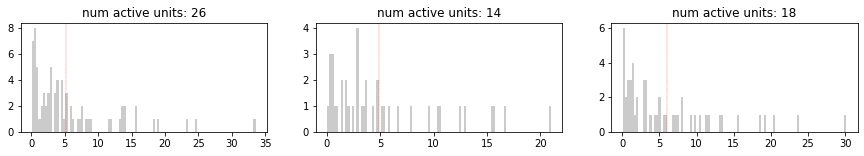

num_pairs: 364
num_pairs: 252
filter_membership.shape (364, 285)
membership cnt [(0, 103740)]
filter_membership.shape (252, 285)
membership cnt [(0, 71820)]
filter_membership.shape (616, 285)
membership cnt [(0, 175560)]


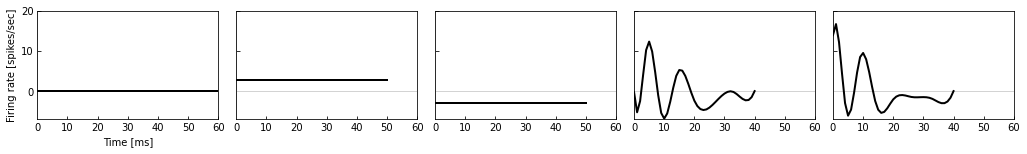

In [12]:
active_firing_rate_quantile_threshold = 0.65
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

# file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_CD_itr149_20210523-070711.pkl'
# filter_membership_CD = util.load_variable(file_path)
# file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_DE_itr149_20210523-070711.pkl'
# filter_membership_DE = util.load_variable(file_path)
filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
model.filter_membership_statistics(filter_membership_CD, verbose=True)
model.filter_membership_statistics(filter_membership_DE, verbose=True)
model.filter_membership_statistics(filter_membership_joint, verbose=True)
group_portion = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/group_model_pars_joint_itr149_20210523-071613.pkl'
group_model_pars = util.load_variable(file_path)
group_model_pars[2]['beta'][2] = -3  # TMP manual modification.
model.plot_multiple_filters(group_model_pars, ylim=[-7, 20], num_rows_cols=[1,5])

#### Estimate optimal kernel width (plug-in estimator)

#all trials:175560	#batch trials:2000
optimal kernel width  55.0


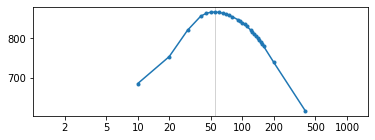

In [13]:
model.estimate_nuisance_kernel_width_together(filter_membership_joint, batch_size=2000)

### Parallel programming.

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   17.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 38618), (1, 41085), (2, 51461), (3, 36730), (4, 30106)]
filter_membership.shape (300, 300)
membership cnt [(0, 12860), (1, 19089), (2, 22371), (3, 18956), (4, 16724)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr0_20211128_043459.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr0_20211128_043459.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr0_20211128_043459.pkl
filter_membership.shape (960, 300)
#all trials:60174	#batch trials:60174
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.259e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:46830	#batch trials:46830
X.shape (1104972, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:09<00:00,  6.38it/s]
num itr 59 [[-1893200.11749249]] 0.013912610997318366
beta [ 1.45105009e+01 -1.99497766e-02  1.34972018e+01  2.07563818e+01 -2.04248866e+01  1.97743072e+01
 -8.61064071e+00  1.15006575e+00 -2.10290434e+00 -1.29257073e-01 -3.73448191e+00]
gradient [-3.09864289 66.81877086 -1.51568267 -1.48931029 -0.46205651 -1.6457972  -0.49083416  0.820907    0.97240012
  0.55671236  0.4944598 ]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.391e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


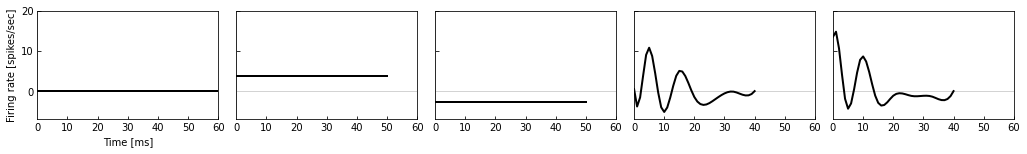

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr0_20211128_044748.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 42857), (1, 42411), (2, 53055), (3, 30807), (4, 28870)]
filter_membership.shape (300, 300)
membership cnt [(0, 14124), (1, 19417), (2, 23417), (3, 16888), (4, 16154)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr1_20211128_045545.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr1_20211128_045545.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr1_20211128_045545.pkl
filter_membership.shape (960, 300)
#all trials:61828	#batch trials:61828
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.673e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:45024	#batch trials:45024
X.shape (1077404, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.68it/s]
num itr 59 [[-1861926.19220451]] 0.01681979877851396
beta [ 1.46686570e+01 -1.87143996e-02  1.51548608e+01  2.17268781e+01 -2.14962017e+01  2.11234943e+01
 -8.69533730e+00  1.38368077e+00 -2.37935861e+00 -2.70379996e-01 -4.00135565e+00]
gradient [-2.43023141 74.14058104 -1.58253109 -1.43277312 -0.34253462 -1.59004967 -0.12821732  0.99648703  1.08287539
  1.03684396  0.84634004]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.682e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


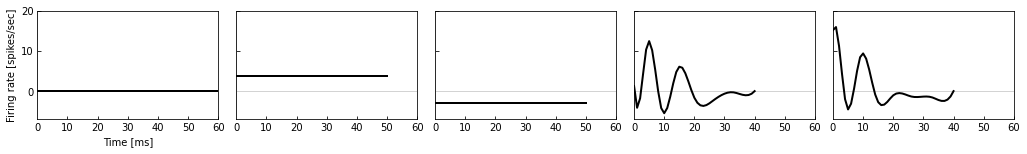

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr1_20211128_050833.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 43597), (1, 41626), (2, 53902), (3, 30437), (4, 28438)]
filter_membership.shape (300, 300)
membership cnt [(0, 14429), (1, 19000), (2, 23666), (3, 16924), (4, 15981)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr2_20211128_051632.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr2_20211128_051632.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr2_20211128_051632.pkl
filter_membership.shape (960, 300)
#all trials:60626	#batch trials:60626
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.077e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44419	#batch trials:44419
X.shape (1065977, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.79it/s]
num itr 59 [[-1845681.3068483]] 0.018835547046407594
beta [ 1.46784286e+01 -2.11883257e-02  1.57998230e+01  2.19737145e+01 -2.18378613e+01  2.17350220e+01
 -8.58474370e+00  1.64006694e+00 -2.75078636e+00  2.59369176e-02 -4.31129695e+00]
gradient [-2.32101444 69.50126394 -1.59067731 -1.44287006 -0.34793831 -1.67522443 -0.27664858  1.01016962  1.16502873
  0.91946171  0.7870286 ]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.884e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


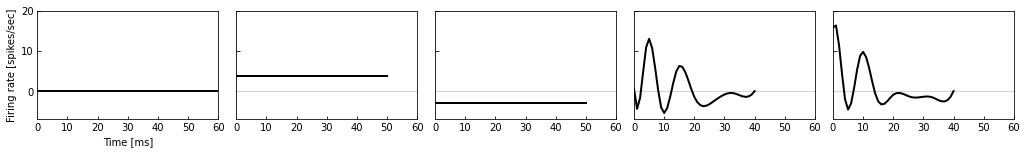

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr2_20211128_052857.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   31.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 43904), (1, 41793), (2, 53828), (3, 30325), (4, 28150)]
filter_membership.shape (300, 300)
membership cnt [(0, 14537), (1, 19034), (2, 23678), (3, 16832), (4, 15919)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr3_20211128_053659.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr3_20211128_053659.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr3_20211128_053659.pkl
filter_membership.shape (960, 300)
#all trials:60827	#batch trials:60827
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.394e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44069	#batch trials:44069
X.shape (1059566, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.85it/s]
num itr 59 [[-1836774.09098136]] 0.018312520442167725
beta [ 14.66065274  -0.02823315  16.26539541  21.72158882 -21.58050307  21.86150348  -8.22956336   1.68259148
  -2.96891172   0.35061241  -4.21401531]
gradient [-2.26215506 79.22963459 -1.58607935 -1.40067658 -0.32735245 -1.67082155 -0.19564156  1.09208434  1.20649754
  0.9747799   0.7858982 ]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.831e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


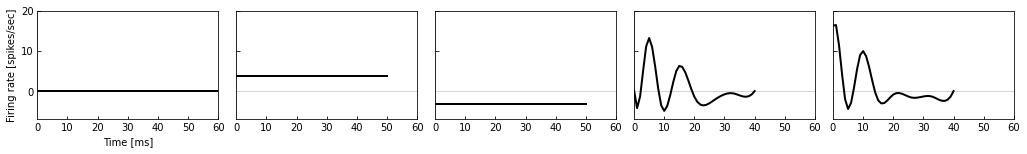

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr3_20211128_054935.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44541), (1, 41686), (2, 54541), (3, 29607), (4, 27625)]
filter_membership.shape (300, 300)
membership cnt [(0, 14842), (1, 19022), (2, 23993), (3, 16462), (4, 15681)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr4_20211128_055732.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr4_20211128_055732.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr4_20211128_055732.pkl
filter_membership.shape (960, 300)
#all trials:60708	#batch trials:60708
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.158e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:43306	#batch trials:43306
X.shape (1046488, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.94it/s]
num itr 59 [[-1819689.73127425]] 0.020237719676011522
beta [ 14.72716794  -0.02677695  16.82927719  22.06171836 -22.22409433  22.48904512  -8.40529396   1.9268937
  -3.25957262   0.69780863  -4.67028202]
gradient [-2.07762761 75.6009964  -1.59159942 -1.37600451 -0.2798995  -1.66609188 -0.18190583  1.06725915  1.18399583
  1.00646643  0.89134365]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.024e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


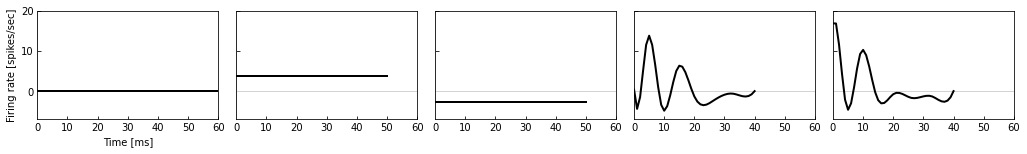

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr4_20211128_061006.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   29.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 43950), (1, 41757), (2, 54366), (3, 29896), (4, 28031)]
filter_membership.shape (300, 300)
membership cnt [(0, 14470), (1, 18966), (2, 24048), (3, 16625), (4, 15891)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr5_20211128_061802.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr5_20211128_061802.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr5_20211128_061802.pkl
filter_membership.shape (960, 300)
#all trials:60723	#batch trials:60723
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.244e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:43922	#batch trials:43922
X.shape (1057218, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.90it/s]
num itr 59 [[-1834111.40501819]] 0.01998255865589051
beta [ 14.67338499  -0.02808441  16.62380961  21.77775458 -22.11892798  22.36859287  -8.29897158   2.123637
  -3.48301821   0.96317369  -4.93763998]
gradient [-2.12178322 82.57277915 -1.59170829 -1.35702166 -0.24474746 -1.66804201 -0.17174459  1.05156367  1.23624507
  1.06005044  0.91694136]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.998e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


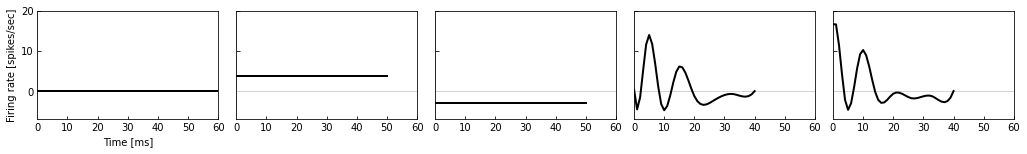

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr5_20211128_063031.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   19.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44534), (1, 41464), (2, 54611), (3, 29523), (4, 27868)]
filter_membership.shape (300, 300)
membership cnt [(0, 14786), (1, 18975), (2, 24004), (3, 16428), (4, 15807)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr6_20211128_063831.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr6_20211128_063831.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr6_20211128_063831.pkl
filter_membership.shape (960, 300)
#all trials:60439	#batch trials:60439
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.460e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:43675	#batch trials:43675
X.shape (1051342, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.79it/s]
num itr 59 [[-1824092.29659677]] 0.019911934189928055
beta [ 14.66745967  -0.02822338  16.67940674  21.85345792 -22.39755283  22.56982322  -8.29795777   2.27820375
  -3.60973463   1.13433279  -5.11123147]
gradient [-2.06854666 82.97496472 -1.58731662 -1.3401183  -0.21912558 -1.67340203 -0.18993421  1.0418688   1.25057397
  1.07270991  0.92921955]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.991e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


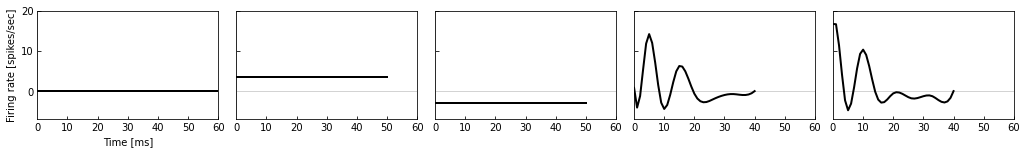

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr6_20211128_065112.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   31.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44160), (1, 40985), (2, 55509), (3, 29040), (4, 28306)]
filter_membership.shape (300, 300)
membership cnt [(0, 14549), (1, 18643), (2, 24470), (3, 16392), (4, 15946)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr7_20211128_065908.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr7_20211128_065908.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr7_20211128_065908.pkl
filter_membership.shape (960, 300)
#all trials:59628	#batch trials:59628
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.574e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44252	#batch trials:44252
X.shape (1060833, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.79it/s]
num itr 59 [[-1836096.41424703]] 0.01968208577826447
beta [ 14.60251042  -0.03029565  16.49953665  21.60269996 -22.29140815  22.42975512  -8.12680848   2.38457234
  -3.78264397   1.40143887  -5.24362655]
gradient [-2.12834333 85.57068242 -1.59257582 -1.33106353 -0.19675409 -1.68867628 -0.20959202  1.08326946  1.3306319
  1.09524402  0.95062277]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.968e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


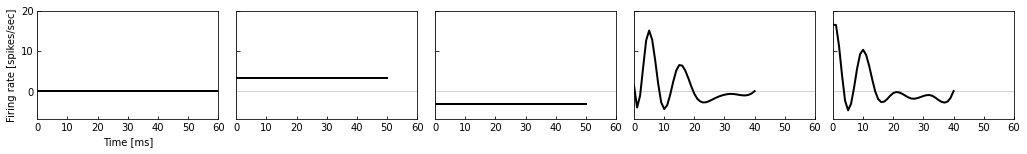

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr7_20211128_071140.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44751), (1, 40936), (2, 55730), (3, 28522), (4, 28061)]
filter_membership.shape (300, 300)
membership cnt [(0, 14810), (1, 18548), (2, 24520), (3, 16235), (4, 15887)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr8_20211128_071936.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr8_20211128_071936.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr8_20211128_071936.pkl
filter_membership.shape (960, 300)
#all trials:59484	#batch trials:59484
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.728e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:43948	#batch trials:43948
X.shape (1054077, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:09<00:00,  6.63it/s]
num itr 59 [[-1825066.48135634]] 0.01967285838290926
beta [ 14.60141266  -0.03015241  16.50682895  21.81542118 -22.67847603  22.67928774  -8.12793282   2.49132902
  -3.86092034   1.53369044  -5.33666271]
gradient [-2.08876901 83.47597672 -1.58567645 -1.31978688 -0.18752183 -1.7074988  -0.26322514  1.01785968  1.27501174
  1.07359051  0.93770171]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.967e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


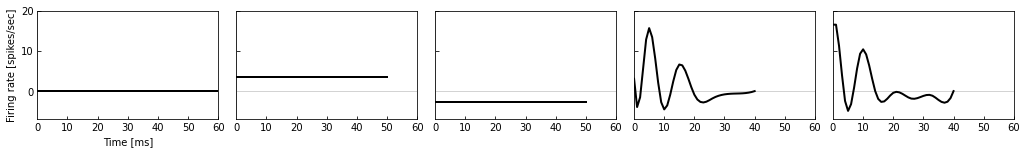

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr8_20211128_073159.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   29.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44044), (1, 41381), (2, 55392), (3, 28686), (4, 28497)]
filter_membership.shape (300, 300)
membership cnt [(0, 14478), (1, 18655), (2, 24546), (3, 16293), (4, 16028)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr9_20211128_073954.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr9_20211128_073954.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr9_20211128_073954.pkl
filter_membership.shape (960, 300)
#all trials:60036	#batch trials:60036
X.sh

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.400e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44525	#batch trials:44525
X.shape (1064042, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.75it/s]
num itr 59 [[-1838249.35027897]] 0.017428882151904967
beta [ 14.57468957  -0.02890977  15.88662126  21.60024794 -22.63315024  22.4009906   -7.92535591   2.44388247
  -3.84600115   1.27970712  -5.27496916]
gradient [-2.24053059 81.8875289  -1.56386322 -1.3088743  -0.19662265 -1.72698881 -0.34137312  0.94827237  1.26814672
  1.10247895  0.92065186]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.743e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


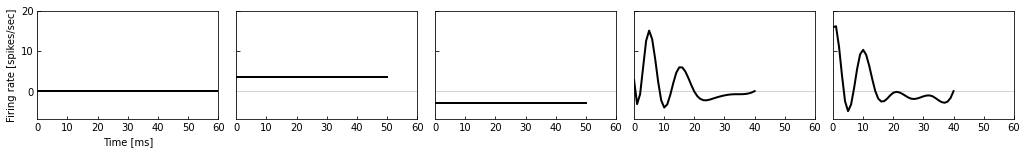

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr9_20211128_075221.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.2min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44472), (1, 41230), (2, 55777), (3, 28162), (4, 28359)]
filter_membership.shape (300, 300)
membership cnt [(0, 14713), (1, 18675), (2, 24632), (3, 16019), (4, 15961)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr10_20211128_080020.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr10_20211128_080020.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr10_20211128_080020.pkl
filter_membership.shape (960, 300)
#all trials:59905	#batch trials:59905
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.833e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44320	#batch trials:44320
X.shape (1057620, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.83it/s]
num itr 59 [[-1825681.40402833]] 0.017921510113643097
beta [ 14.5418851   -0.02813459  15.69682749  21.81783572 -23.12689884  22.72997783  -8.08694854   2.60044468
  -3.86162364   1.54729596  -5.39040655]
gradient [-2.18927322 83.78287893 -1.55069331 -1.29065559 -0.17527394 -1.72839991 -0.3119448   0.87291241  1.12160171
  1.01372465  0.89913548]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.792e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


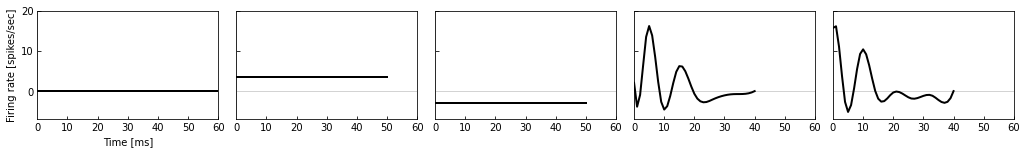

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr10_20211128_081253.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   29.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44413), (1, 41380), (2, 55474), (3, 28313), (4, 28420)]
filter_membership.shape (300, 300)
membership cnt [(0, 14680), (1, 18702), (2, 24551), (3, 16112), (4, 15955)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr11_20211128_082051.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr11_20211128_082051.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr11_20211128_082051.pkl
filter_membership.shape (960, 300)
#all trials:60082	#batch trials:60082
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.442e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44375	#batch trials:44375
X.shape (1060048, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.82it/s]
num itr 59 [[-1830868.35013077]] 0.017830656113070695
beta [ 14.55888038  -0.02821727  15.67178727  21.62458802 -23.2139733   22.73054745  -8.03698926   2.54079988
  -3.78839138   1.49675152  -5.25178061]
gradient [-2.22822841 83.14838168 -1.54351766 -1.27208966 -0.17470845 -1.75222683 -0.37179261  0.81911109  1.0691029
  1.01347624  0.869029  ]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.783e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


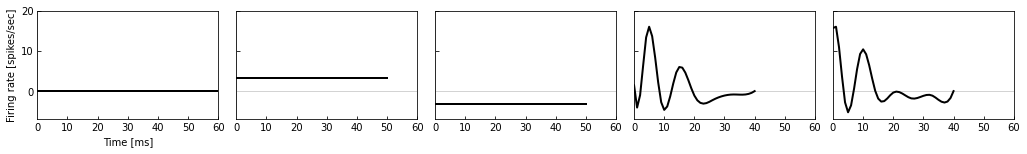

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr11_20211128_083316.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   29.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   17.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44581), (1, 40796), (2, 55749), (3, 28540), (4, 28334)]
filter_membership.shape (300, 300)
membership cnt [(0, 14675), (1, 18593), (2, 24496), (3, 16220), (4, 16016)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr12_20211128_084111.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr12_20211128_084111.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr12_20211128_084111.pkl
filter_membership.shape (960, 300)
#all trials:59389	#batch trials:59389
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.442e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44350	#batch trials:44350
X.shape (1062403, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.84it/s]
num itr 59 [[-1837935.51238467]] 0.01632738437230057
beta [ 14.59148661  -0.02900131  15.8866569   21.75937508 -23.5831983   23.14431323  -8.42320758   2.80219705
  -3.87653204   1.36671887  -4.85989348]
gradient [-2.24442027 75.75164793 -1.55157113 -1.27591516 -0.21698415 -1.77582656 -0.31733475  0.83899289  1.13616386
  0.98865332  0.7452308 ]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.633e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


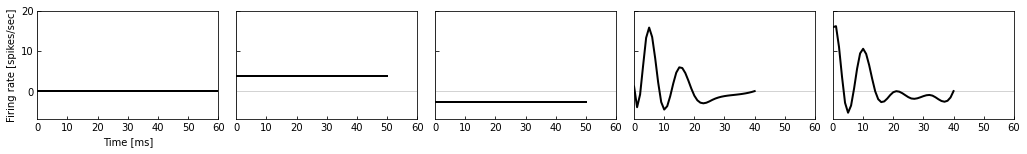

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr12_20211128_085329.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   29.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   19.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44030), (1, 41823), (2, 54912), (3, 28751), (4, 28484)]
filter_membership.shape (300, 300)
membership cnt [(0, 14504), (1, 18824), (2, 24326), (3, 16272), (4, 16074)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr13_20211128_090126.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr13_20211128_090126.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr13_20211128_090126.pkl
filter_membership.shape (960, 300)
#all trials:60647	#batch trials:60647
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.652e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44558	#batch trials:44558
X.shape (1065052, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.85it/s]
num itr 59 [[-1840139.2349777]] 0.018503404769025348
beta [ 14.57699717  -0.02665827  15.94190519  21.3460891  -23.3832458   22.85877784  -8.12798888   2.59780101
  -3.7936019    1.5226049   -5.35837854]
gradient [-2.19323347 80.32707112 -1.55165853 -1.25191421 -0.1408573  -1.74771753 -0.36768689  0.89115388  1.08729899
  0.9905644   0.93546512]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.850e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


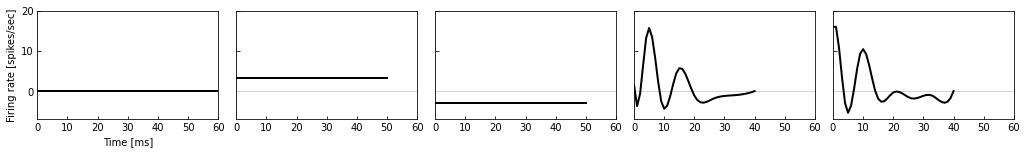

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr13_20211128_091351.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44246), (1, 41188), (2, 55452), (3, 28506), (4, 28608)]
filter_membership.shape (300, 300)
membership cnt [(0, 14574), (1, 18658), (2, 24489), (3, 16184), (4, 16095)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr14_20211128_092148.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr14_20211128_092148.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr14_20211128_092148.pkl
filter_membership.shape (960, 300)
#all trials:59846	#batch trials:59846
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.329e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44703	#batch trials:44703
X.shape (1066818, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.72it/s]
num itr 59 [[-1841468.88625299]] 0.015951839007429625
beta [ 14.54900634  -0.02885177  15.86056259  21.15608905 -23.33010009  22.88947853  -8.34579982   2.79255503
  -3.8669436    1.43359761  -4.9652001 ]
gradient [-2.35837594 74.36346162 -1.55110791 -1.2710931  -0.24292553 -1.79004355 -0.32994559  0.82216491  1.17145993
  0.99382789  0.74987136]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.595e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


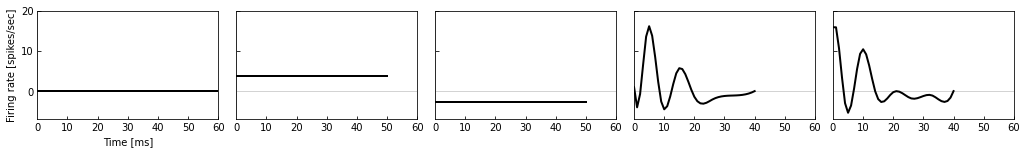

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr14_20211128_093418.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44477), (1, 41635), (2, 55139), (3, 28452), (4, 28297)]
filter_membership.shape (300, 300)
membership cnt [(0, 14636), (1, 18847), (2, 24411), (3, 16101), (4, 16005)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr15_20211128_094212.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr15_20211128_094212.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr15_20211128_094212.pkl
filter_membership.shape (960, 300)
#all trials:60482	#batch trials:60482
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.326e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44302	#batch trials:44302
X.shape (1061081, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.75it/s]
num itr 59 [[-1835319.34585144]] 0.01647589940117007
beta [ 14.62614426  -0.02508466  15.99742154  20.8640333  -23.14541257  23.05388828  -8.74474822   2.96557544
  -3.86603221   1.42579121  -5.51904392]
gradient [-2.21569519 72.69665358 -1.53835544 -1.25419797 -0.26734063 -1.78979516 -0.18874634  0.90516498  1.1109631
  1.05355472  0.99016149]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.648e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


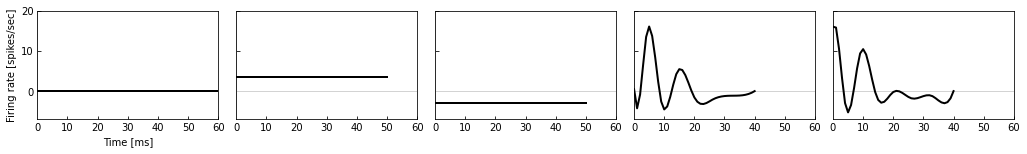

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr15_20211128_095439.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   17.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44505), (1, 41632), (2, 55000), (3, 28518), (4, 28345)]
filter_membership.shape (300, 300)
membership cnt [(0, 14737), (1, 18953), (2, 24242), (3, 16095), (4, 15973)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr16_20211128_100233.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr16_20211128_100233.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr16_20211128_100233.pkl
filter_membership.shape (960, 300)
#all trials:60585	#batch trials:60585
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.268e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44318	#batch trials:44318
X.shape (1059039, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.83it/s]
num itr 59 [[-1829400.60651804]] 0.016156783915243677
beta [ 1.46057535e+01 -2.27010564e-02  1.61214399e+01  2.07243741e+01 -2.32685891e+01  2.29297757e+01
 -8.37909536e+00  2.70215368e+00 -3.71174759e+00  1.23904109e+00 -5.63468217e+00]
gradient [-2.1423137  79.53376666 -1.54062091 -1.19594482 -0.10569227 -1.74196836 -0.32768786  0.96657745  1.21774196
  1.10911679  0.98713515]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.616e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


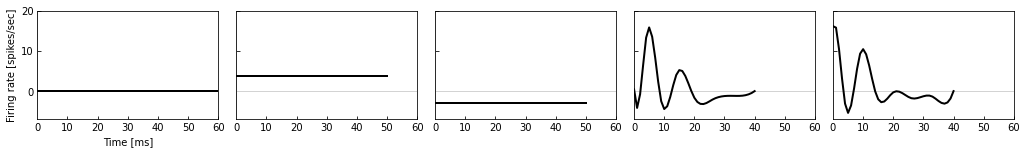

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr16_20211128_101453.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44727), (1, 41749), (2, 54791), (3, 28382), (4, 28351)]
filter_membership.shape (300, 300)
membership cnt [(0, 14816), (1, 18999), (2, 24224), (3, 16030), (4, 15931)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr17_20211128_102249.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr17_20211128_102249.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr17_20211128_102249.pkl
filter_membership.shape (960, 300)
#all trials:60748	#batch trials:60748
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.748e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44282	#batch trials:44282
X.shape (1056661, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.91it/s]
num itr 59 [[-1823735.04868739]] 0.01766552064125861
beta [ 14.57430242  -0.02440265  16.18456255  20.45804034 -23.21894276  22.81847851  -8.27879826   2.70917801
  -3.67262312   1.32687222  -5.49714394]
gradient [-2.14029918e+00  8.66194632e+01 -1.53804120e+00 -1.17120515e+00 -6.29749534e-02 -1.71135442e+00
 -2.75381087e-01  9.19355447e-01  1.14830641e+00  1.07270878e+00  9.53419267e-01]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.767e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


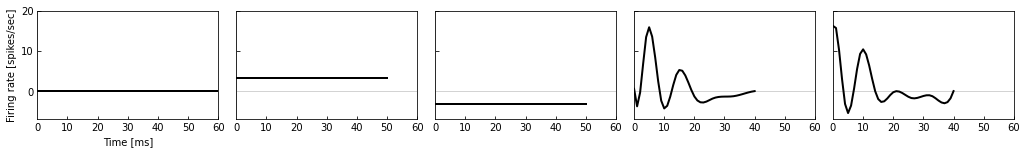

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr17_20211128_103511.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44609), (1, 40987), (2, 55664), (3, 28271), (4, 28469)]
filter_membership.shape (300, 300)
membership cnt [(0, 14774), (1, 18681), (2, 24498), (3, 16048), (4, 15999)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr18_20211128_104308.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr18_20211128_104308.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr18_20211128_104308.pkl
filter_membership.shape (960, 300)
#all trials:59668	#batch trials:59668
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.669e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44468	#batch trials:44468
X.shape (1061630, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.79it/s]
num itr 59 [[-1832937.67152089]] 0.01603624827205073
beta [ 14.57429459  -0.02540632  16.29974904  20.57734089 -23.5197033   23.07000425  -8.54295899   2.8932707
  -3.76881695   1.31304707  -5.16285166]
gradient [-2.19000895e+00  8.17770849e+01 -1.55154195e+00 -1.17719547e+00 -7.73911706e-02 -1.72309361e+00
 -2.31099782e-01  9.16184156e-01  1.17317097e+00  1.03761542e+00  8.31803697e-01]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.604e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


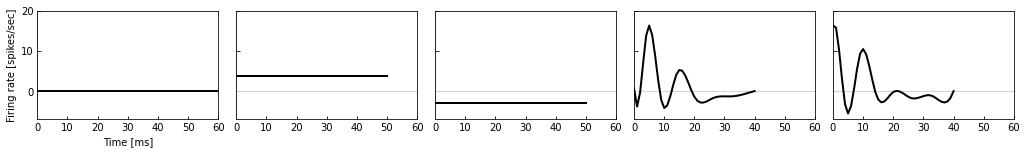

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr18_20211128_105555.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44818), (1, 41642), (2, 55378), (3, 27876), (4, 28286)]
filter_membership.shape (300, 300)
membership cnt [(0, 14917), (1, 18817), (2, 24437), (3, 15858), (4, 15971)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr19_20211128_110352.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr19_20211128_110352.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr19_20211128_110352.pkl
filter_membership.shape (960, 300)
#all trials:60459	#batch trials:60459
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.674e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44257	#batch trials:44257
X.shape (1056783, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.87it/s]
num itr 59 [[-1824740.33570604]] 0.015966570380337473
beta [ 14.58398919  -0.02486322  16.2343908   20.55634903 -23.68568533  23.09739313  -8.70961907   2.94870976
  -3.73047349   1.14077309  -4.84407954]
gradient [-2.22501826e+00  8.07939130e+01 -1.54077200e+00 -1.16379381e+00 -6.87915247e-02 -1.70095704e+00
 -2.37725378e-01  8.55841963e-01  1.09554206e+00  1.01491396e+00  7.96575763e-01]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.597e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


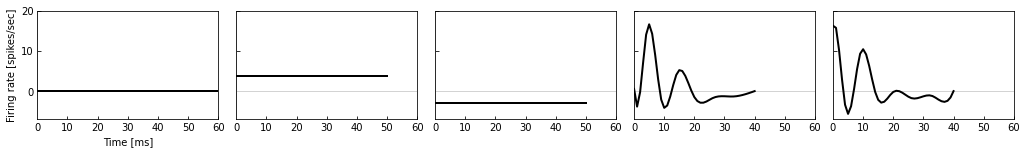

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr19_20211128_111618.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.2min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44927), (1, 41661), (2, 55365), (3, 27742), (4, 28305)]
filter_membership.shape (300, 300)
membership cnt [(0, 14936), (1, 18902), (2, 24428), (3, 15803), (4, 15931)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr20_20211128_112417.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr20_20211128_112417.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr20_20211128_112417.pkl
filter_membership.shape (960, 300)
#all trials:60563	#batch trials:60563
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.704e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44236	#batch trials:44236
X.shape (1056250, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.76it/s]
num itr 59 [[-1823720.27775032]] 0.01615617268441939
beta [ 14.58572015  -0.02435329  16.12940601  20.7615386  -23.70057409  23.14937652  -8.9455352    3.08712561
  -3.74455291   0.898845    -4.56182853]
gradient [-2.2213417  79.99341808 -1.54322207 -1.21496009 -0.14733911 -1.70715372 -0.18800601  0.85416555  1.11973761
  1.05724574  0.79404144]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.616e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


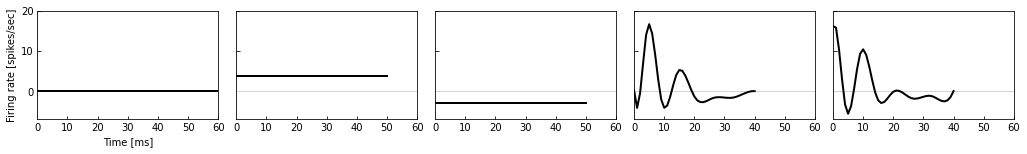

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr20_20211128_113647.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   19.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44718), (1, 41733), (2, 55230), (3, 27874), (4, 28445)]
filter_membership.shape (300, 300)
membership cnt [(0, 14801), (1, 18899), (2, 24384), (3, 15916), (4, 16000)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr21_20211128_114446.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr21_20211128_114446.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr21_20211128_114446.pkl
filter_membership.shape (960, 300)
#all trials:60632	#batch trials:60632
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.457e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44445	#batch trials:44445
X.shape (1060499, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.76it/s]
num itr 59 [[-1830296.3595522]] 0.016030962228159668
beta [ 14.5806777   -0.02416092  16.06971088  20.80777441 -23.70079237  23.09850314  -9.08203926   3.13933752
  -3.71346384   0.747031    -4.35943898]
gradient [-2.28553803 75.98837576 -1.55007111 -1.22384669 -0.15754548 -1.70895344 -0.20396214  0.83047504  1.10486678
  1.03112132  0.75604282]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.603e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


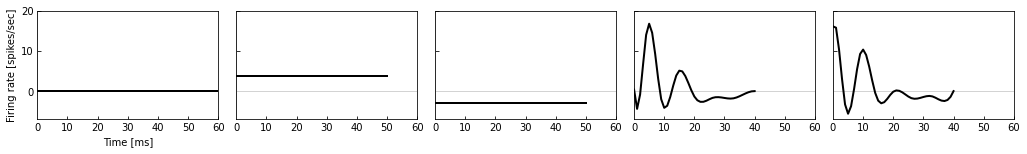

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr21_20211128_115706.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44947), (1, 41676), (2, 55227), (3, 27851), (4, 28299)]
filter_membership.shape (300, 300)
membership cnt [(0, 14940), (1, 18883), (2, 24345), (3, 15870), (4, 15962)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr22_20211128_120502.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr22_20211128_120502.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr22_20211128_120502.pkl
filter_membership.shape (960, 300)
#all trials:60559	#batch trials:60559
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.462e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44261	#batch trials:44261
X.shape (1058335, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.81it/s]
num itr 59 [[-1828686.55819308]] 0.016868300576305523
beta [ 1.46277625e+01 -2.02551034e-02  1.61685394e+01  2.06702042e+01 -2.34475049e+01  2.32561506e+01
 -9.39238400e+00  3.27781225e+00 -3.72933232e+00  9.36322253e-01 -5.18765202e+00]
gradient [-2.47681394 34.43344172 -1.54787849 -1.35027587 -0.626208   -1.96772275 -0.3094795   0.53538141  0.61613591
  0.84819764  1.03703139]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.687e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


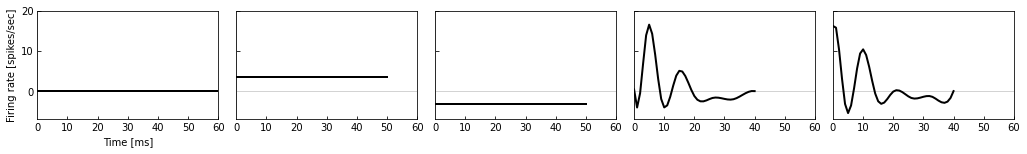

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr22_20211128_121727.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 45168), (1, 41423), (2, 55418), (3, 27715), (4, 28276)]
filter_membership.shape (300, 300)
membership cnt [(0, 15041), (1, 18871), (2, 24447), (3, 15757), (4, 15884)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr23_20211128_122524.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr23_20211128_122524.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr23_20211128_122524.pkl
filter_membership.shape (960, 300)
#all trials:60294	#batch trials:60294
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.474e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44160	#batch trials:44160
X.shape (1053553, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.91it/s]
num itr 59 [[-1818102.54710842]] 0.015745181827264396
beta [ 1.45839888e+01 -2.29837791e-02  1.60715913e+01  2.07933983e+01 -2.36236253e+01  2.30745798e+01
 -9.18293411e+00  3.24157681e+00 -3.71645856e+00  8.84706658e-01 -4.74646541e+00]
gradient [-2.21760107 80.01955394 -1.54261704 -1.20693413 -0.09108293 -1.6596101  -0.22223464  0.84308337  1.11701494
  1.04763688  0.78827075]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.575e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


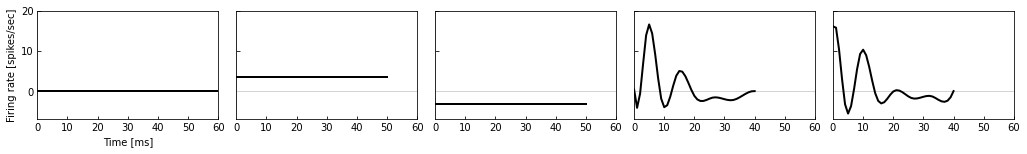

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr23_20211128_123745.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.2min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44656), (1, 41382), (2, 55585), (3, 28044), (4, 28333)]
filter_membership.shape (300, 300)
membership cnt [(0, 14787), (1, 18744), (2, 24496), (3, 15915), (4, 16058)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr24_20211128_124545.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr24_20211128_124545.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr24_20211128_124545.pkl
filter_membership.shape (960, 300)
#all trials:60126	#batch trials:60126
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.302e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44391	#batch trials:44391
X.shape (1060394, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.79it/s]
num itr 59 [[-1831317.35637282]] 0.01594396085563582
beta [ 14.59827705  -0.02434571  16.3038698   20.73764482 -23.64837413  23.05755223  -9.20913377   3.23991037
  -3.73766001   0.79323288  -4.39818702]
gradient [-2.4165818  59.5943778  -1.55952373 -1.24299938 -0.25720846 -1.77420577 -0.31090042  0.7583931   1.07820503
  0.94253707  0.67491722]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.594e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


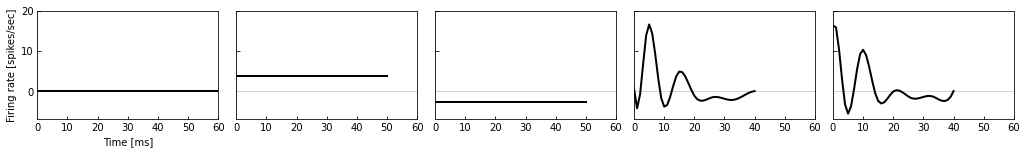

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr24_20211128_125830.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 44433), (1, 41946), (2, 55260), (3, 27959), (4, 28402)]
filter_membership.shape (300, 300)
membership cnt [(0, 14617), (1, 19000), (2, 24422), (3, 15907), (4, 16054)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr25_20211128_130629.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr25_20211128_130629.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr25_20211128_130629.pkl
filter_membership.shape (960, 300)
#all trials:60946	#batch trials:60946
X

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.474e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:44456	#batch trials:44456
X.shape (1061798, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:09<00:00,  6.34it/s]
num itr 59 [[-1833561.78898998]] 0.0160795738382759
beta [ 1.46047238e+01 -2.32033475e-02  1.64895678e+01  2.06786928e+01 -2.38612111e+01  2.30365209e+01
 -9.22855592e+00  3.19782847e+00 -3.65574483e+00  6.14779033e-01 -4.15960476e+00]
gradient [-2.30886493 69.09416878 -1.56760276 -1.18794729 -0.10153789 -1.69400049 -0.26179826  0.78771933  1.00305175
  0.96221169  0.70723876]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.608e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


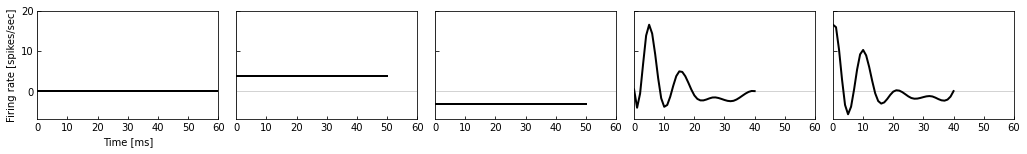

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr25_20211128_131855.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  4.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  3.1min finished


filter_membership.shape (660, 300)
membership cnt [(0, 45077), (1, 41580), (2, 55361), (3, 27856), (4, 28126)]
filter_membership.shape (300, 300)
membership cnt [(0, 15028), (1, 18930), (2, 24350), (3, 15805), (4, 15887)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_CD_itr26_20211128_132653.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/filter_membership_DE_itr26_20211128_132653.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_portion_itr26_20211128_132653.pkl
filter_membership.shape (960, 300)
#all trials:60510	#batch trials:60510
X

KeyboardInterrupt: 

In [35]:
output_dir = project_dir + f'Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/'

for itr in range(0, 30):
    jobs_CD, jobs_DE = [], []
    for trial_id in selected_trial_ids:
        job1 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                       filter_membership_CD, [trial_id], parallel=True)
        job2 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                       filter_membership_DE, [trial_id], parallel=True)
        jobs_CD.append(job1)
        jobs_DE.append(job2)
    with Parallel(n_jobs=num_paral_jobs, verbose=1) as parallel_pool:
        jobs_CD_out = parallel_pool(jobs_CD)
        jobs_DE_out = parallel_pool(jobs_DE)
    filter_membership_CD = pd.concat(jobs_CD_out, axis=1)
    filter_membership_DE = pd.concat(jobs_DE_out, axis=1)
    model.filter_membership_statistics(filter_membership_CD)
    model.filter_membership_statistics(filter_membership_DE)
    file_path = output_dir + f'filter_membership_CD_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, filter_membership_CD)
    file_path = output_dir + f'filter_membership_DE_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, filter_membership_DE)

    filter_membership_joint = filter_membership_CD.append(filter_membership_DE)

#     group_portion = model.update_membership_portion(5, filter_membership_joint)
    file_path = output_dir + f'group_portion_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, group_portion)

    group_model_pars = model.update_cluster_filter_joint_trail(filter_membership_joint, verbose=True)
    model.plot_multiple_filters(group_model_pars, ylim=[-7, 20], num_rows_cols=[1,5])
    file_path = output_dir + f'group_model_pars_joint_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, group_model_pars)